# CS 445 Final Project - Image Morphing

## Setup and Load Images

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltpath

from scipy.spatial import Delaunay
from scipy.spatial import voronoi_plot_2d, Voronoi

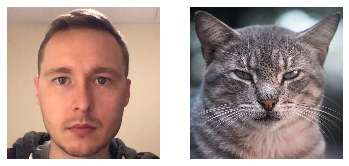

In [2]:
# Read in the source and target images
source_img = cv2.imread('./images/inputs/andrew.jpg')
target_img = cv2.imread('./images/inputs/cat.jpg')

assert source_img.shape == target_img.shape
H, W, C = source_img.shape

fix, axes = plt.subplots(1, 2)
[a.axis('off') for a in axes.ravel()]
axes[0].imshow(cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))

## Select Corresponding Points

In [3]:
'''
Display the image and collect points clicked on the image.

Heavily referenced from UIUC CS445 MP3 utils.py in starter code.
'''
def specify_points(img):
    fig = plt.figure()
    fig.set_label('Select corresponding points in the image')
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    clicked = []
    
    def on_mouse_pressed(event):
        x = round(event.xdata)
        y = round(event.ydata)
        plt.plot(x, y, 'r+')
        clicked.append([x, y])
        
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    
    return clicked

<IPython.core.display.Javascript object>


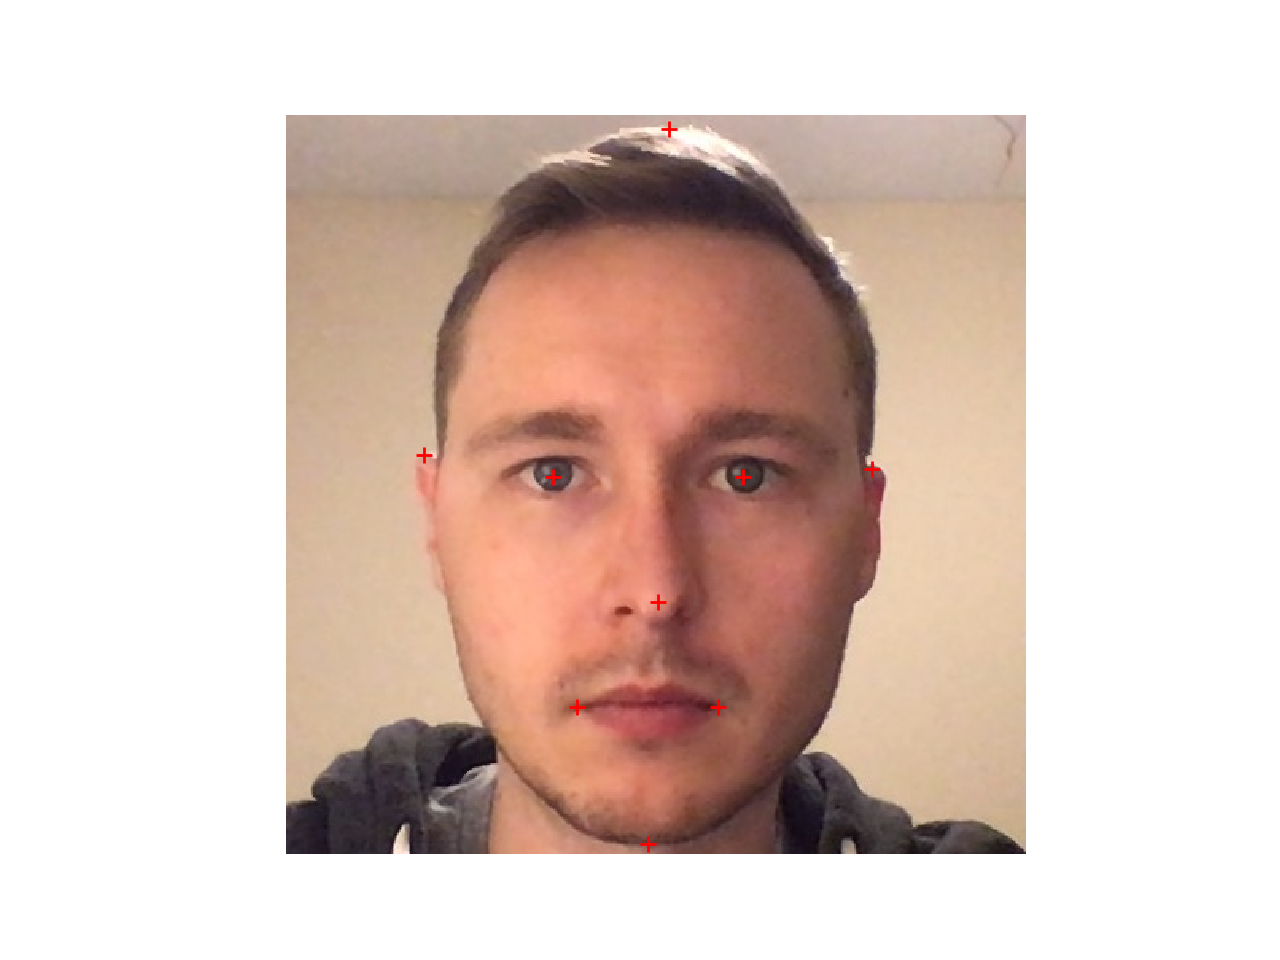

In [4]:
# Select corresponding points on the images
%matplotlib notebook
source_points = specify_points(source_img)

<IPython.core.display.Javascript object>


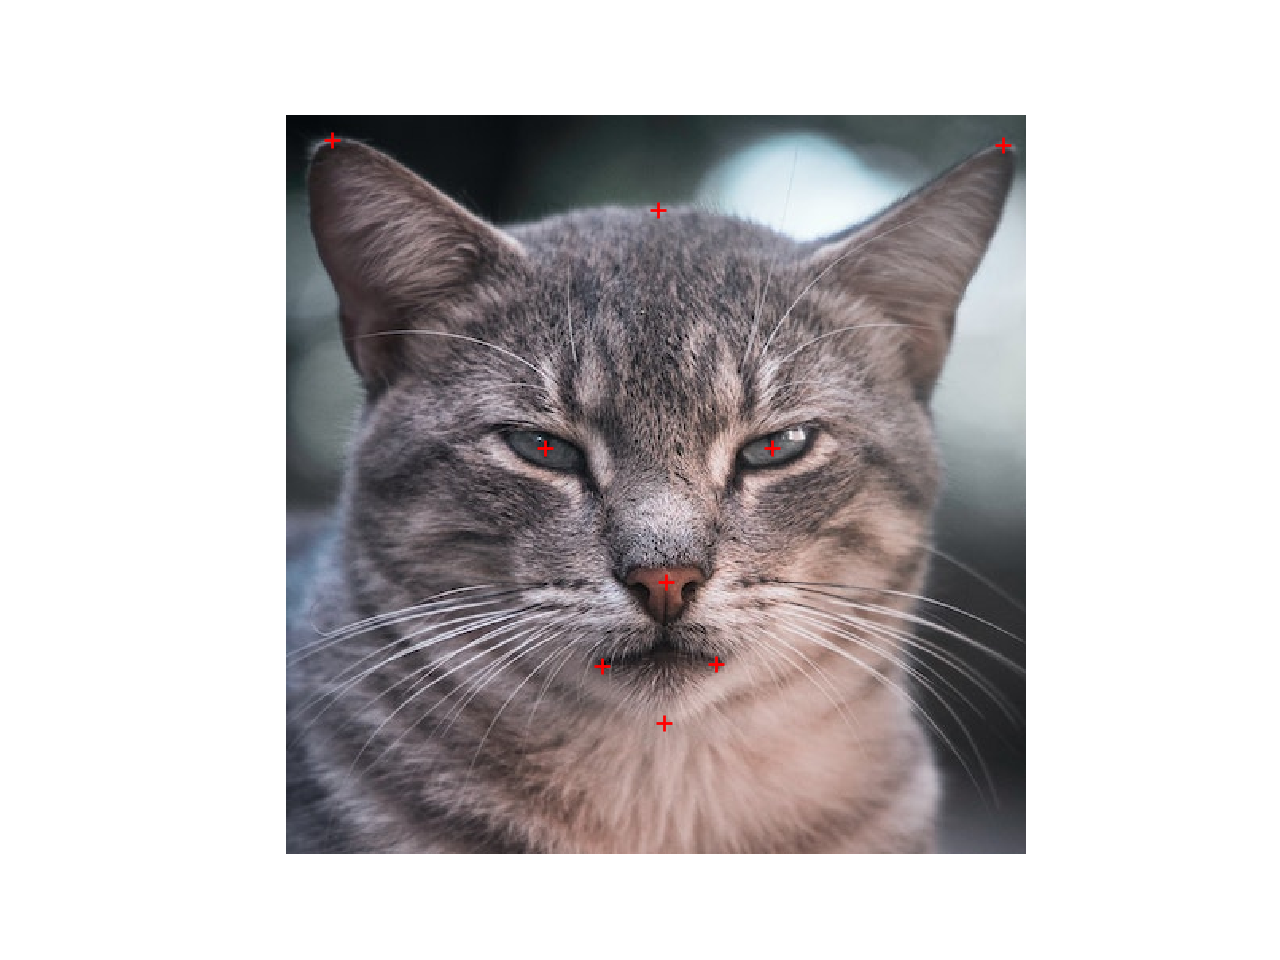

In [5]:
%matplotlib notebook
target_points = specify_points(target_img)

In [6]:
print(source_points)
print(target_points)

[[167.0, 227.0], [287.0, 227.0], [86.0, 213.0], [368.0, 222.0], [182.0, 372.0], [271.0, 372.0], [233.0, 306.0], [240.0, 8.0], [227.0, 458.0]]
[[162.0, 209.0], [305.0, 209.0], [28.0, 15.0], [450.0, 18.0], [198.0, 346.0], [270.0, 345.0], [238.0, 293.0], [233.0, 59.0], [237.0, 382.0]]


In [7]:
# Add the points at the corners of the images
source_points.extend([[0, 0], [0, W-1], [H-1, 0], [H-1, W-1]])
target_points.extend([[0, 0], [0, W-1], [H-1, 0], [H-1, W-1]])
assert len(source_points) == len(target_points)

<IPython.core.display.Javascript object>


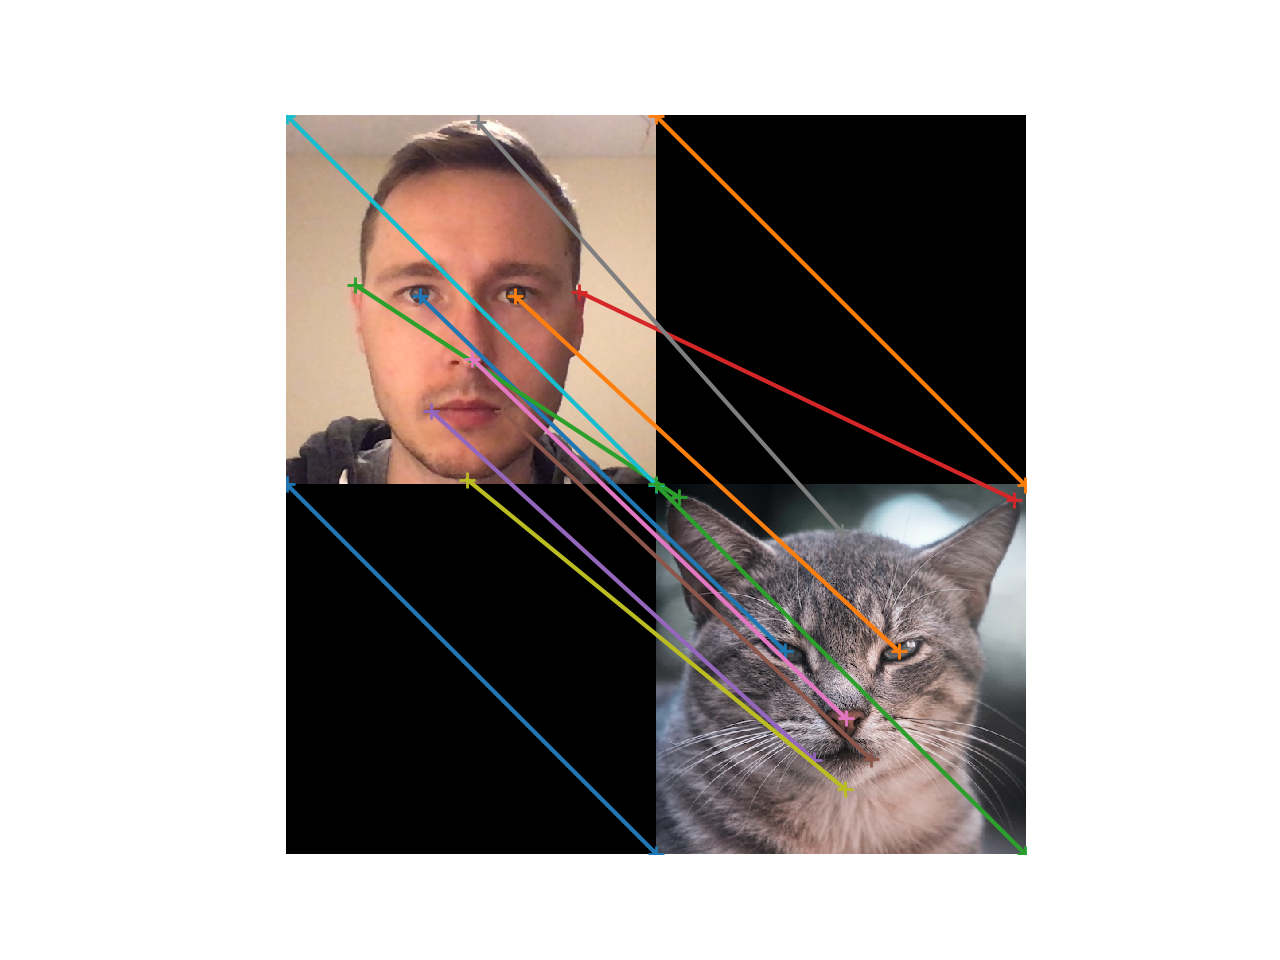

In [8]:
# Display the connected points to verify
mapping_img = np.zeros(shape=(2 * H, 2 * W, C), dtype='uint16')
for h in range(0, H):
    for w in range(0, W):
        for c in range(0, C):
            mapping_img[h][w][c] = source_img[h][w][c]
            mapping_img[h+H][w+W][c] = target_img[h][w][c]

fig = plt.figure()
plt.axis('off')
plt.imshow(cv2.cvtColor(mapping_img, cv2.COLOR_BGR2RGB))

for p in range(0, len(source_points)):
    x1 = source_points[p][0]
    y1 = source_points[p][1]
    x2 = target_points[p][0] + W
    y2 = target_points[p][1] + H
    plt.plot([x1, x2], [y1, y2], marker = '+')

## Compute Delaunay Triangulation

In [40]:
triangulation = Delaunay(source_points)
#target_triangulation = Delaunay(target_points)

print(triangulation.simplices)
# print(target_triangulation.simplices)

[[ 2 10  9]
 [11  7  9]
 [ 7  2  9]
 [ 8 12 10]
 [12  3 11]
 [ 3  7 11]
 [ 7  3  1]
 [ 2  4 10]
 [ 4  8 10]
 [ 3  5  1]
 [ 4  5  8]
 [ 8  5 12]
 [ 5  3 12]
 [ 0  4  2]
 [ 0  7  1]
 [ 7  0  2]
 [ 6  5  4]
 [ 0  6  4]
 [ 5  6  1]
 [ 6  0  1]]


In [41]:
def plot_triangulation(img, points, triangulation):
    fig = plt.figure()
    v = Voronoi(points)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.triplot(points[:,0], points[:,1], triangulation.simplices.copy(), c='#FF0000')
    plt.plot(points[:,0], points[:,1], 'r+')

<IPython.core.display.Javascript object>


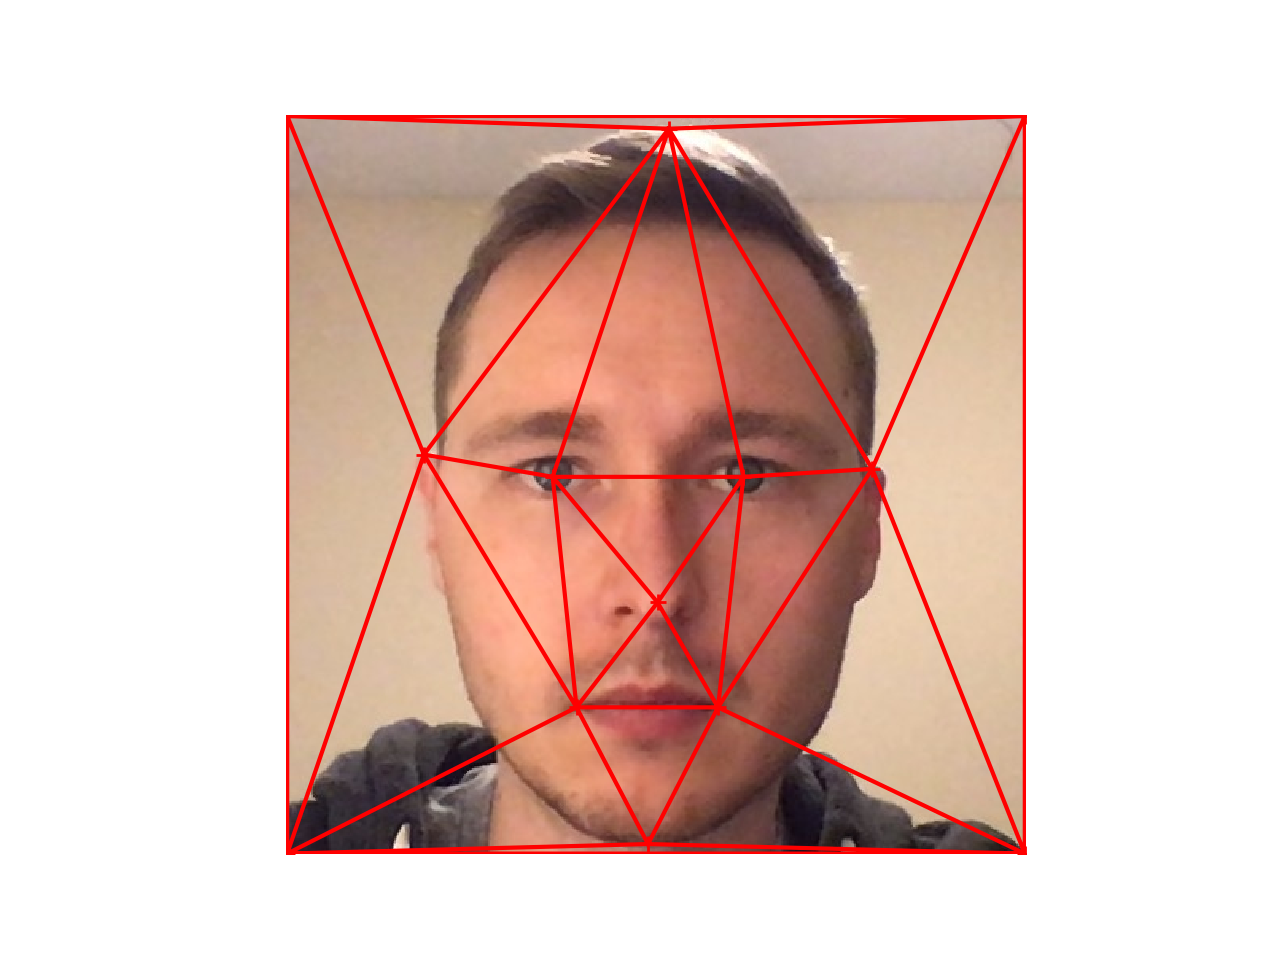

<IPython.core.display.Javascript object>


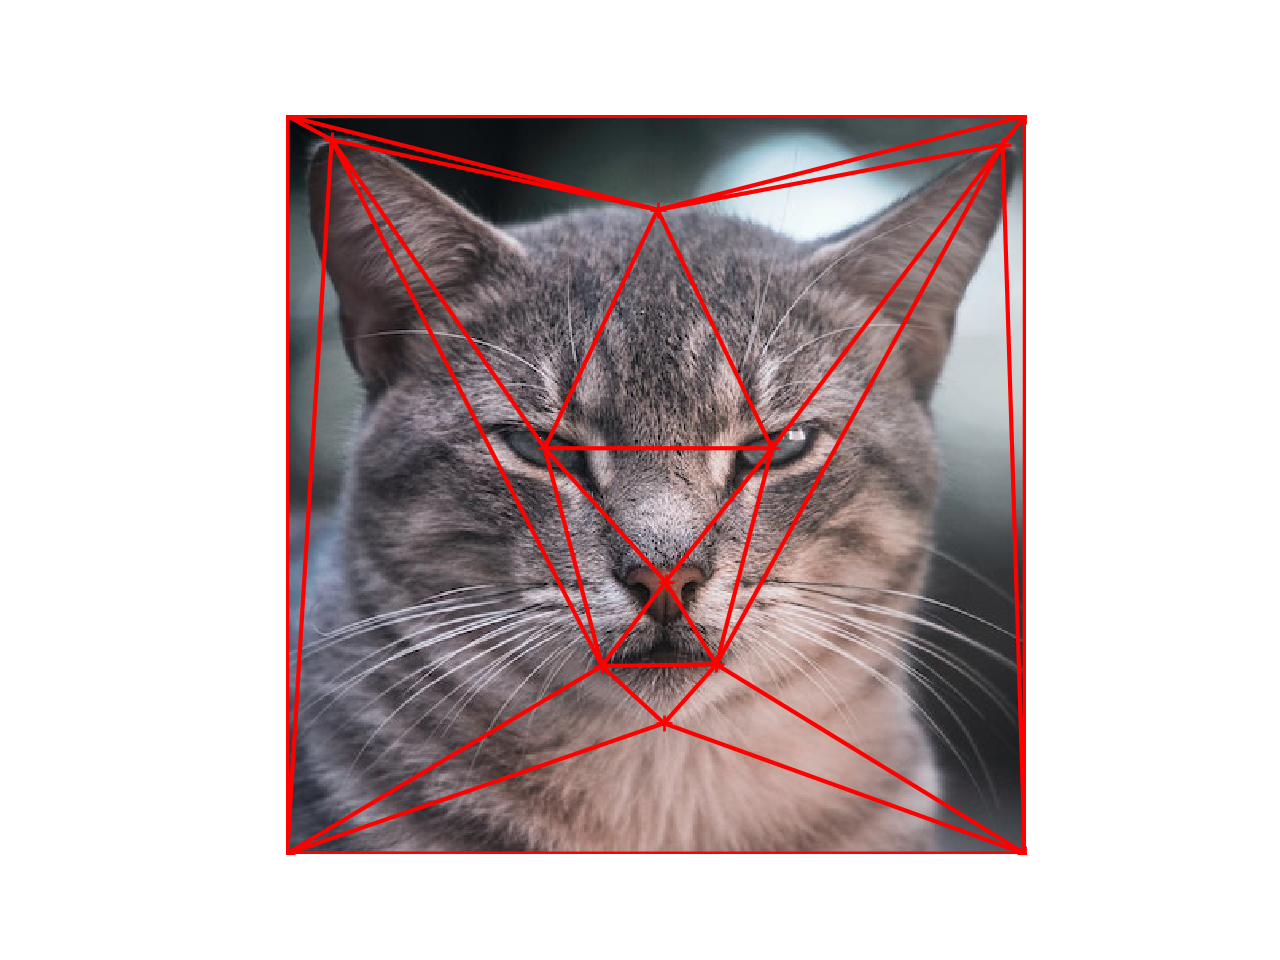

In [42]:
source_points = np.array(source_points)
target_points = np.array(target_points)

plot_triangulation(source_img, source_points, triangulation)
plot_triangulation(target_img, target_points, triangulation)

In [65]:
def get_points_in_triangle(x1, y1, x2, y2, x3, y3):
    min_x = int(min(x1, x2, x3))
    max_x = int(max(x1, x2, x3))
    min_y = int(min(y1, y2, y3))
    max_y = int(max(y1, y2, y3))
    path = mpltpath.Path([[x1,y1],[x2,y2],[x3,y3]], codes=None, closed=True)
#     inside2 = path.contains_points(points)
#     area = (x1*y2 + x2*y3 + x3*y1 - x1*y3 - x2*y1 - x3*y2) / 2
    points = []
    for x in range(min_x, max_x+1):
        for y in range(min_y, max_y+1):
#             s = 1 / (2 * area) * (y1*x3 - x1*y3 + (y3 - y1)*x + (x1 - x3)*y)
#             t = 1 / (2 * area) * (x1*y2 - y1*x2 + (y1 - y2)*x + (x2 - x1)*y)
#             if s > 0 and t > 0 and (1-s-t) > 0:
            if path.contains_points([[x,y]]):
                points.append([x,y])
    return np.array(points)

def get_points_in_triangulation(triangle, triangulation):
#     print(triangulation.simplices)
#     print(triangle[triangulation.simplices])
    xs = list()
    ys = list()
    for vertex in triangle[triangulation.simplices][0]:
        xs.append(vertex[0])
        ys.append(vertex[1])
    points = list()
    for x in range(int(min(xs)), int(max(xs)) + 1):
        for y in range(int(min(ys)), int(max(ys)) + 1):
            simplices = triangulation.find_simplex(np.array([(x,y)]))
            if simplices[0] != -1:
                points.append([x,y])
    return np.array(points)

<IPython.core.display.Javascript object>


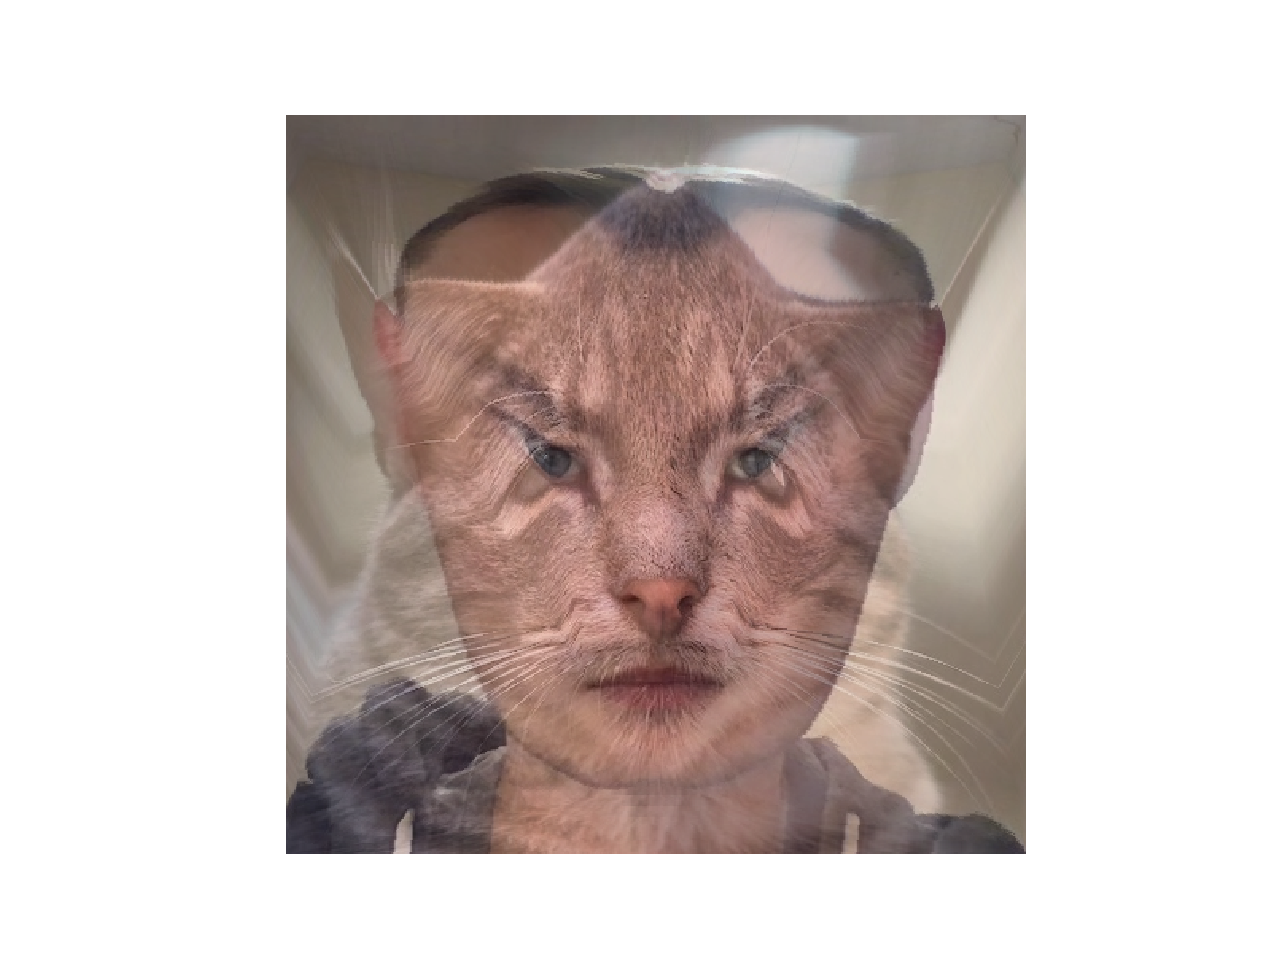

In [77]:
num_triangles = len(triangulation.simplices)
# Compute the average shape (t=0.5)
average_img = np.zeros(shape=(H, W, C), dtype='uint8')
t = 0.5
average_triangles = np.zeros(shape=(num_triangles, 3, 2), dtype=np.float32)
total_average_points = 0
for triangle_index in range(0, num_triangles):
    simplices = triangulation.simplices[triangle_index]
    for v in range(0, 3):
        simplex = triangulation.simplices[triangle_index][v]
        P = source_points[simplex]
        Q = target_points[simplex]
        average_triangles[triangle_index][v] = P + t * (Q - P)
        
    # Compute the affine projection to the source and target triangles
    source_triangle = np.float32([
        source_points[simplices[0]],
        source_points[simplices[1]],
        source_points[simplices[2]]
    ])
    target_triangle = np.float32([
        target_points[simplices[0]],
        target_points[simplices[1]],
        target_points[simplices[2]]
    ])
    average_triangle = np.float32(average_triangles[triangle_index])
    source_transform = cv2.getAffineTransform(average_triangle, source_triangle)
    target_transform = cv2.getAffineTransform(average_triangle, target_triangle)
    
    average_triangulation = Delaunay(average_triangle)
    
    # For each point in the average triangle, find the corresponding points
    # in the source and target triangle, and find the weighted average.
    average_points = get_points_in_triangulation(average_triangle, average_triangulation)
    total_average_points += len(average_points)
    for point in average_points:
        source_point = np.transpose(np.dot(source_transform, np.transpose(np.array([point[0], point[1], 1]))))
        target_point = np.transpose(np.dot(target_transform, np.transpose(np.array([point[0], point[1], 1]))))

#         print('{} corresponds to source point: {}'.format(point, source_point))
        # Perform a weighted average per-channel
        for c in range(0, C):
            source_val = source_img[int(source_point[1]), int(source_point[0]), c]
            target_val = target_img[int(target_point[1]), int(target_point[0]), c]
            average_img[point[1], point[0], c] = round((1-t) * source_val + t * target_val)
# print(total_average_points)

fig = plt.figure()
plt.axis('off')
plt.imshow(cv2.cvtColor(average_img, cv2.COLOR_BGR2RGB))